In [1]:
# import stand alone packages
import torch
import importlib
import yaml
import pandas as pd
import numpy as np
import torch.distributions as dist
import matplotlib.pyplot as plt
import networkx as nx
from pysmiles import read_smiles
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import importlib
import selfies
import torch.nn.functional as TorchF
import sys

# import our own functins
from chemdm.vae import auxiliary_functions
from chemdm.vae import data_loader
from chemdm.vae import chemistry_vae_symmetric_rnn_final

from chemdm.mlp import properties_searcher_2



*Pipeline steps:*

*VAE:* 

The first step is to simply train a VAE. Ideal hyperparameters are already set up in the 'selfies_rnn.yml' file. The functions within the VAE are fairly generic, i.e., save models, save scores, etc. The VAE is fed datasets in SMILES form, after which it converts the dataset to SELFIES. There is an option to use SMILES however this is redundant and will be removed in the quality of life stuff.

The VAE saves a model every 50 epochs, you should be able to generate a good model after that many epochs. 

Some stuff that needs adding:

 - Removal of the SMILES function.
 - Addition of a strong validation function for the validation set in the VAE.
 - Usage of randomiser seeds so that the validation sets in the VAE and QM9 are the same.
 - Function that saves the alphabet in a readable form for the MLP, this would save us having to type it into the settings of the MLP every time.

*MLP:*

The settings within the perceptron are slightly more confusing. Since the VAE randomises the input dataset, the alphabets are inconsistent and so we have to specifiy the alphabet of the VAE every time. The MLP has generic functions, similar to the VAE. 


*Analysis:*

Our analysis for QM9 involves looking at the validation dataset and seeing if the perceptron is capable of predicting the HOMO-LUMO gaps. I.e., whether the perceptron can figure out the HOMO-LUMO gaps of data unseen by the VAE. 

Furthermore, in this notebook. All of the non-generic functions will be displayed.

Ultimately, we should have a plot that demonstrates how good the perceptron is at predicting the HOMO-LUMO gaps for unseen molecules. This would be analagous to generating some new latent vectors defined by the latent space. However, since QM9 is complete, we cannot really generate any new molecules, hence the benchmark nature of the paper.

*Check for long:*

The check for long file is a mess. But it is basically what we use to generate our benchmarks, it will be cleaned up over the coming week so it is readable

In [2]:
# in order to train the RNN vae run
# chemistry_vae_symmetric_rnn_final.main()

In [2]:
# here we want to read in data and tranform them into one_hot
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

qm9_path = "../chemdm/datasets/filtered_qm9_energies.csv"

selfies_list, selfies_alphabet, largest_selfies_len, smiles_list, smiles_alphabet, largest_smiles_len = chemistry_vae_symmetric_rnn_final.get_selfie_and_smiles_encodings_for_dataset(qm9_path)

{'H': 1, 'F': 1, 'Cl': 1, 'Br': 1, 'I': 1, 'B': 3, 'B+1': 2, 'B-1': 4, 'O': 2, 'O+1': 3, 'O-1': 1, 'N': 3, 'N+1': 4, 'N-1': 2, 'C': 4, 'C+1': 5, 'C-1': 3, 'P': 5, 'P+1': 6, 'P-1': 4, 'S': 6, 'S+1': 7, 'S-1': 5, '?': 8}
                  smiles  energy_gap
0       N#CC1NC11C2CC1C2      0.2818
1         OC1=NON=C1OC=O      0.2271
2        CC12CCC1CN1CC21      0.3036
3        CN=C1OC(=O)CC1N      0.2451
4         CC(CO)C(CO)C#N      0.3048
...                  ...         ...
130687  CC1CC2(OCC12)C#C      0.2649
130688  CC(=O)C12CCC1CO2      0.2115
130689  CC1(CNC1=O)C1CN1      0.2719
130690  CC1=NC2C3CC2C3O1      0.2617
130691   CCN1C=C(O)N=C1C      0.2227

[130692 rows x 2 columns]
--> Translating SMILES to SELFIES...
27
Finished translating SMILES to SELFIES.


In [20]:
# load the trained vae models to encode and decode latent space vectors 

file_to_load =  "../chemdm/example_models/100stack_size1neurons_num2048_l_dim64num_count1/250/"
training_file_nameE = "E.pt"
training_file_nameD = "D.pt"

largest_selfies_len_dataset = largest_selfies_len
largest_smiles_len_dataset = largest_smiles_len

#in_dimension = len(selfies_alphabet)*largest_selfies_len
in_dimension = len(smiles_alphabet)*largest_smiles_len


# load the trained encoder
vae_encoder = chemistry_vae_symmetric_rnn_final.VAEEncoder(972, 1, 2048, 64)
vae_encoder.load_state_dict(torch.load(file_to_load + training_file_nameE, map_location=torch.device('cpu')))
#print(vae_encoder)

# load the trained decoder
vae_decoder = chemistry_vae_symmetric_rnn_final.VAEDecoder(64, 1, 512, 27)
vae_decoder.load_state_dict(torch.load(file_to_load + training_file_nameD, map_location=torch.device(device="cpu")))
#print(vae_decoder)

<All keys matched successfully>

In [5]:
# this alphabet was used in training 
selfies_alphabet = [
    "[nop]",
    "[N-1]",
    "[Ring1]",
    "[=Branch2]",
    "[Branch1]",
    "[=O]",
    "[C]",
    "[CH1-1]",
    "[=C]",
    "[C-1]",
    "[NH2+1]",
    "[=NH2+1]",
    "[O]",
    "[NH3+1]",
    "[Branch2]",
    "[#Branch1]",
    "[#Branch2]",
    "[N]",
    "[NH1+1]",
    "[O-1]",
    "[#N]",
    "[=NH1+1]",
    "[Ring2]",
    "[F]",
    "[=N]",
    "[=Branch1]",
    "[#C]"
]

***VAE USAGE:***

In [6]:
importlib.reload(auxiliary_functions)

<module 'auxiliary_functions' from '/Users/sammcd/chemDM/vae/../vae/auxiliary_functions.py'>

In [7]:
###Step 0: Decide what data you want to analyse

# 1. For just one SELFIE:
selfie_input = [selfies_list[0]] ### Choose the SELFIE you want

# 2. For all/multiple SELFIES:

#selfie_input = selfie_list[:1000]


In [8]:
###Step 1: Generate the one hot representations of your input/s.

data = auxiliary_functions.multiple_selfies_to_onehot(selfie_input, largest_selfies_len, selfies_alphabet)
data = torch.tensor(data, dtype=torch.float).to(device)

In [9]:
###Step 2: Generate the latent vectors

mus = auxiliary_functions.gen_latent_vectors(vae_encoder, data)

In [10]:
###Step 3: Decode the latent vectors

# The outputs will all be in SMILES

# 1. For a single latent point:

final_smiles_list = auxiliary_functions.decode_single_lpoint(vae_decoder, data.shape[1], mus, selfies_alphabet, device)

# 2. For all/multiple latent points:

#final_smiles_list = auxiliary_functions.decode_lpoint(vae_decoder, data.shape[1], mus, selfies_alphabet, device)

*Example usage:*

cinnamon

Visual of the chemical itself:


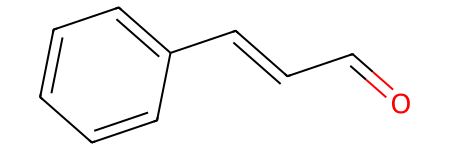

In [11]:
###Step 1: Input your SMILES molecule and convert to a SELFIES

smiles_input = 'C1=CC=C(C=C1)C=CC=O'

selfie_cinnamon = [selfies.encoder(smiles_input)]

molToDraw= Chem.MolFromSmiles(smiles_input)

print('Visual of the chemical itself:')
display(molToDraw)

In [12]:
###Step 2: Convert the molecule to a one hot representation:

data_cinnamon = auxiliary_functions.multiple_selfies_to_onehot(selfie_cinnamon, largest_selfies_len, selfies_alphabet)
data_cinnamon = torch.tensor(data_cinnamon, dtype=torch.float).to(device)

In [13]:
###Step 3: Convert the one hot representation to a latent vector:

cinnamon_lpoint  = auxiliary_functions.gen_latent_vectors(vae_encoder, data_cinnamon)

In [14]:
###Step 4: Decode the cinnamon latent vector

cinnamon_smiles = auxiliary_functions.decode_single_lpoint(vae_decoder, data.shape[1], mus, selfies_alphabet, device)

In [15]:
print('cinnamon input:', smiles_input, 'cinnamon recreation:', cinnamon_smiles[0])

cinnamon input: C1=CC=C(C=C1)C=CC=O cinnamon recreation: N#CC1NC12C3CC2C3


***MLP:***

In [16]:
# validate perceptron model
mlp = torch.load('../example_models/mlp/0.9105536752248934', map_location = "cpu")

**Plotting the mean relative errors:**

*Note:*

This example will use the first 10,000 molecules in the dataset. I believe all of these molecules are ones that the MLP has actually trained on so you would expect predictions to be good.

In [17]:
###Step 0: Decide what data you want to analyse

#We will look at the first 10000 molecules

selfie_input = selfies_list[:10000]


In [18]:
###Step 1: Generate the one hot representations of your input/s.

data = auxiliary_functions.multiple_selfies_to_onehot(selfie_input, largest_selfies_len, selfies_alphabet)
data = torch.tensor(data, dtype=torch.float).to(device)

In [19]:
###Step 2: Generate the latent vectors

mus = auxiliary_functions.gen_latent_vectors(vae_encoder, data)

In [20]:
###Step 3: Take the true HOMO-LUMO gaps and prepare the data


my_file = pd.read_csv("../datasets/filtered_qm9_energies.csv", index_col=None)## The file you want to train on, should contain SMILES reps, latent space reps and properties

properties_df = my_file.drop(columns=['smiles']) ## drop all smiles from the properties df
properties_array = properties_df.to_numpy() ## convert the df to numpy array
properties_tensor = torch.tensor(properties_array,dtype=torch.float32).to(device)
properties_tensor = properties_tensor[:10000]



sorted_props, props_index = torch.sort(properties_tensor, dim=0)
mus_ordered = torch.empty(0, dtype=torch.float32).to(device)
for x in props_index:
    mus_ordered = torch.cat((mus_ordered, mus[x]), dim = 0)

In [21]:
###Step 4: Predict the HOMO-LUMO gaps


mlp.eval()
with torch.no_grad():
    HL_predictions = mlp(mus_ordered)


In [22]:
###Step 5: Prepare the data

abs_dif = torch.sqrt((sorted_props-HL_predictions)**2)
rel_dif = abs_dif/sorted_props

preds_list = HL_predictions.squeeze().tolist()
sorted_list = sorted_props.squeeze().tolist()
abs_list = abs_dif.squeeze().tolist()
rel_list = rel_dif.squeeze().tolist()

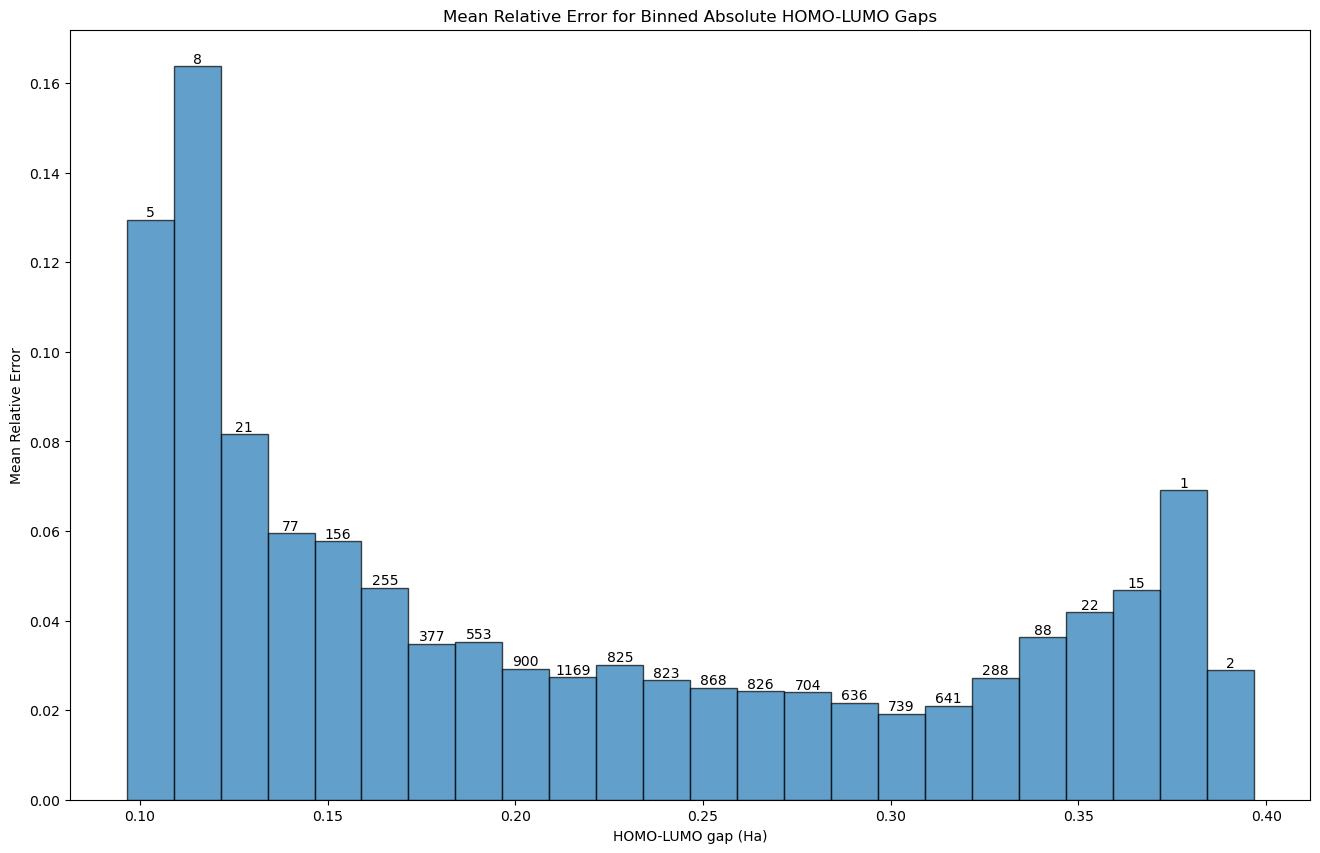

In [23]:
def autolabel(rects, counts):
    for i in range(len(rects)):
        height = rects[i].get_height()
        plt.text(rects[i].get_x() + rects[i].get_width()/2., height , '%d' % int(counts[i]), ha='center', va='bottom')

plt.figure(figsize=(16, 10))

absolute_values = sorted_list
relative_errors = rel_list
bins = np.linspace(min(absolute_values), max(absolute_values), 25)  
digitized = np.digitize(absolute_values, bins)
unique_values, counts = np.unique(digitized, return_counts=True)

mean_relative_errors = [np.mean(np.array(relative_errors)[digitized == i]) for i in range(1, len(bins))]
unique_values, counts = np.unique(digitized, return_counts=True)

# Create the bar plot
bars = plt.bar(bins[:-1], mean_relative_errors, width=np.diff(bins), edgecolor='black', alpha=0.7)

# Call the autolabel function to add labels above each bar
autolabel(bars, counts)

plt.xlabel('HOMO-LUMO gap (Ha)')
plt.ylabel('Mean Relative Error')
plt.title('Mean Relative Error for Binned Absolute HOMO-LUMO Gaps')

# Show the plot
plt.show()